## Sentiment Analysis for hotel review data - Spark
#### Yuye Sheng 2020.3

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "2g").appName('testtest').getOrCreate()

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
%matplotlib inline
# load the dataset
df = pd.read_csv('Hotel_Reviews.csv')
# df.head()

### Data Preprocessing

In [8]:
# for each row, combine positive and negative review together
df['all_review'] = df.apply(lambda x:x['Positive_Review']+' '+x['Negative_Review'],axis=1)
df["all_review"] = df["all_review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", "")) # if negative text is NA, it will show 'No Negative', so remove them. 
# df['all_review'].head()

# create labels(classes)
# if score>6,that review's label is identified as positive (i.e.1)
df["label"] = df["Reviewer_Score"].apply(lambda x: 1 if x > 6 else 0)
# select only relevant columns
reviews_df = df[["all_review", "label"]]
# reviews_df.to_csv("Cleaned_hotel_review_data.csv",index=False)  # save processed data to a csv file for training deep learning model
reviews_df.head()

,all_review,label
0,Only the park outside of the hotel was beauti...,0
1,No real complaints the hotel was great great ...,1
2,Location was good and staff were ok It is cut...,1
3,Great location in nice surroundings the bar a...,0
4,Amazing location and building Romantic settin...,1


In [4]:
# our data is imbalancing
reviews_df["label"].value_counts(normalize=True)

1    0.8977
0    0.1023
Name: label, dtype: float64

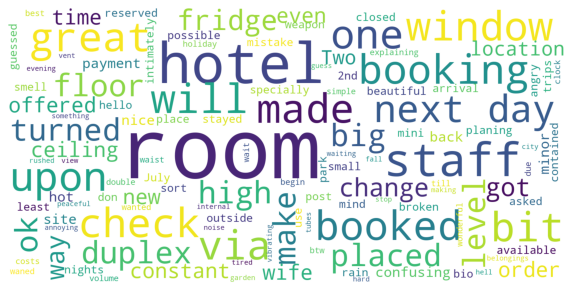

In [7]:
# Word cloud
from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(max_font_size=60, max_words = 120,background_color = 'white',scale = 4,stopwords=STOPWORDS).generate(str(reviews_df['all_review'].values))
# wordcloud.to_file('wordcloud.png')   # save word cloud to local computer
fig = plt.figure(1, figsize = (10, 13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Feature extraction

In [6]:
df_spark = spark.createDataFrame(reviews_df)

In [7]:
# tokenize the review texts using spark 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="all_review", outputCol="words")
wordsData = tokenizer.transform(df_spark)  # convert sentence to words

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='words_clean')
wordsData = remover.transform(wordsData).drop("words")

hashingTF = HashingTF(inputCol="words_clean", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)  # convert each sentence to a vector where each element represent a word

# TF-IDF reflect the importance of a term(word) to a document in the corpus, return a feature vector for each document
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)  # use TF-IDF score to compute the feature importance
# for features_label in rescaledData.select("features", "label").take(3):
#     print(features_label)

### Non-deep model training

In [25]:
# function of constructing the plots of confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
# split training and test set
(train,test) = rescaledData.randomSplit([0.8,0.2],seed=100)

In [11]:
# balance the training set using randomly under-sampling
# randomly select 15% positive data and all negative data
train_posi = train[train["label"]==1].sample(fraction=0.15, withReplacement=False, seed=50)
train_neg = train[train["label"]==0]
train_ = train_posi.unionAll(train_neg)  # final training set used for model training

#### SVM

In [12]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train_)

# Print the coefficients and intercept for linearsSVC
# print("Coefficients: " + str(lsvcModel.coefficients))
# print("Intercept: " + str(lsvcModel.intercept))

train_prediction = lsvcModel.transform(train)
test_prediction = lsvcModel.transform(test)

evaluator = BinaryClassificationEvaluator()
evaluation_train = evaluator.evaluate(train_prediction)
evaluation_test = evaluator.evaluate(test_prediction)

# "Area Under Curve": 
print("training AOC: %f" % evaluation_train)
print("test AOC: %f" % evaluation_test)  

training AOC: 0.928814
test AOC: 0.895067


In [29]:
# retrieve predicted labels and compute the evaluation metrics
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
y_true_train = train_prediction.select("label")
y_true_train = y_true_train.toPandas()
y_pred_train = train_prediction.select("prediction")
y_pred_train = y_pred_train.toPandas()

print(precision_recall_fscore_support(y_true_train,y_pred_train))

cnf_matrix = confusion_matrix(y_true_train, y_pred_train)
print(cnf_matrix)

y_true_test = test_prediction.select("label")
y_true_test = y_true_test.toPandas()

y_pred = test_prediction.select("prediction")
y_pred = y_pred.toPandas()

print(precision_recall_fscore_support(y_true_test,y_pred))

cnf_matrixt = confusion_matrix(y_true_test, y_pred)
print(cnf_matrixt)

(array([0.44227699, 0.97651972]), array([0.8136874 , 0.88306264]), array([0.57306595, 0.92744275]), array([ 42214, 370412], dtype=int64))
[[ 34349   7865]
 [ 43315 327097]]
(array([0.40513515, 0.96702459]), array([0.73762564, 0.87660696]), array([0.52301072, 0.91959859]), array([10546, 92566], dtype=int64))
[[ 7779  2767]
 [11422 81144]]


Normalized confusion matrix
[[0.8136874  0.1863126 ]
 [0.11693736 0.88306264]]
Normalized confusion matrix
[[0.73762564 0.26237436]
 [0.12339304 0.87660696]]


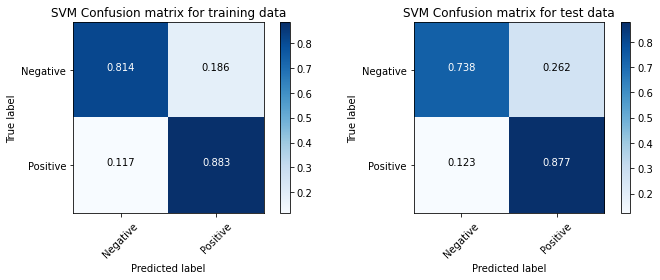

In [30]:
# plot confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=["Negative","Positive"],normalize=True,
                      title='SVM Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(cnf_matrixt, classes=["Negative","Positive"],normalize=True,
                      title='SVM Confusion matrix for test data')
plt.savefig("svm_confusionmx")
plt.show()

#### Naive Bayes

In [19]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
nbModel = nb.fit(train_)

# predict 
nb_predictions_train = nbModel.transform(train)
nb_predictions_test = nbModel.transform(test)

# compute evaluate measure
evaluator = BinaryClassificationEvaluator()
evaluation_train_nb = evaluator.evaluate(nb_predictions_train)
evaluation_test_nb = evaluator.evaluate(nb_predictions_test)

# "Area Under Curve":
print("training evaluation (area under ROC): %f" % evaluation_train_nb)
print("test evaluation (area under ROC): %f" % evaluation_test_nb)

training evaluation (area under ROC): 0.633043
test evaluation (area under ROC): 0.631566


In [20]:
# retrieve predicted labels and compute the evaluation metrics
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
y_true_train = nb_predictions_train.select("label")
y_true_train = y_true_train.toPandas()
y_pred_train = nb_predictions_train.select("prediction")
y_pred_train = y_pred_train.toPandas()

print(precision_recall_fscore_support(y_true_train,y_pred_train))

cnf_matrix = confusion_matrix(y_true_train, y_pred_train)
print(cnf_matrix)

# test confusion matrix
y_true_test = nb_predictions_test.select("label")
y_true_test = y_true_test.toPandas()

y_pred = nb_predictions_test.select("prediction")
y_pred = y_pred.toPandas()

print(precision_recall_fscore_support(y_true_test,y_pred))

cnf_matrixt = confusion_matrix(y_true_test, y_pred)
print(cnf_matrixt)

(array([0.33786253, 0.97594096]), array([0.82347089, 0.81608047]), array([0.47913881, 0.88888039]), array([ 42214, 370412], dtype=int64))
[[ 34762   7452]
 [ 68126 302286]]
(array([0.31838407, 0.96917101]), array([0.77346861, 0.81134542]), array([0.45108666, 0.88326336]), array([10546, 92566], dtype=int64))
[[ 8157  2389]
 [17463 75103]]


Normalized confusion matrix
[[0.82347089 0.17652911]
 [0.18391953 0.81608047]]
Normalized confusion matrix
[[0.77346861 0.22653139]
 [0.18865458 0.81134542]]


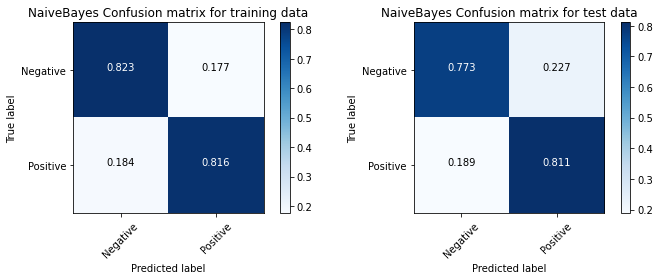

In [27]:
# plot confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=["Negative","Positive"],normalize=True,
                      title='NaiveBayes Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(cnf_matrixt, classes=["Negative","Positive"],normalize=True,
                      title='NaiveBayes Confusion matrix for test data')
plt.savefig("nb_confusionmx")
plt.show()